In [3]:
%%capture
!pip install -U sentence-transformers
import numpy as np
import pandas as pd
from nltk.tokenize import TweetTokenizer
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn


In [4]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/EECS 498 Applied ML for Affective Computing')

In [5]:
from data import *
from ratio_classification import *

In [6]:
%load_ext autoreload
%autoreload 2

# Setup Model

In [64]:
subreddit = 'UTAustin'
df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/EECS 498 Applied ML for Affective Computing/data/{subreddit}.csv")
df = filterData(df)
df = generateFeatures(df)
df


,Title,Text,Timestamp,Upvotes,Upvote_ratio,Num_comments,Nsfw,Text_Only,Subreddit,Url,Content,Num_votes
0,Double Majoring at McCombs?,Hi! I’m a prospective undergrad for the McComb...,1.648808e+09,0,0.50,4,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/ttn...,double majoring at mccombs? hi! i’m a prospect...,0.0
1,Anyone know of a really good Pilates studio ne...,,1.648798e+09,4,1.00,0,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/ttk...,anyone know of a really good pilates studio ne...,4.0
2,Hiss-tory of a Claw-ful Midnight,I was heading to san jac after doing a little ...,1.648794e+09,2,0.75,2,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/ttj...,hiss-tory of a claw-ful midnight i was heading...,2.0
3,Enroll in both 1st and 2nd summer semesters or...,I've heard how fast paced summer courses are s...,1.648784e+09,6,1.00,4,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/tth...,enroll in both 1st and 2nd summer semesters or...,6.0
4,Today's episode of Young Sheldon references UT...,Young Sheldon's friend/nemesis Paige visits hi...,1.648783e+09,3,0.64,1,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/ttg...,today's episode of young sheldon references ut...,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41162,What's your favorite place to study on-campus?,"I usually stick with the PCL, but lately I've ...",1.300910e+09,10,0.92,21,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/g9y...,what's your favorite place to study on-campus?...,10.0
41163,I DECLARE THIS SUBREDDIT ALIVE AGAIN!!!!!,"Of course, I have no authority (and don't want...",1.300907e+09,28,0.89,16,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/g9w...,i declare this subreddit alive again!!!!! of c...,34.0
41164,"Hey Reddit, I'm looking for one roommate for a...",,1.278879e+09,1,0.67,0,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/coe...,"hey reddit, i'm looking for one roommate for a...",1.0
41165,Best way to improve campus/student life,Import 1000 squirrels on campus. I fucking lov...,1.274557e+09,3,0.80,2,False,True,UTAustin,https://www.reddit.com/r/UTAustin/comments/c72...,best way to improve campus/student life import...,5.0


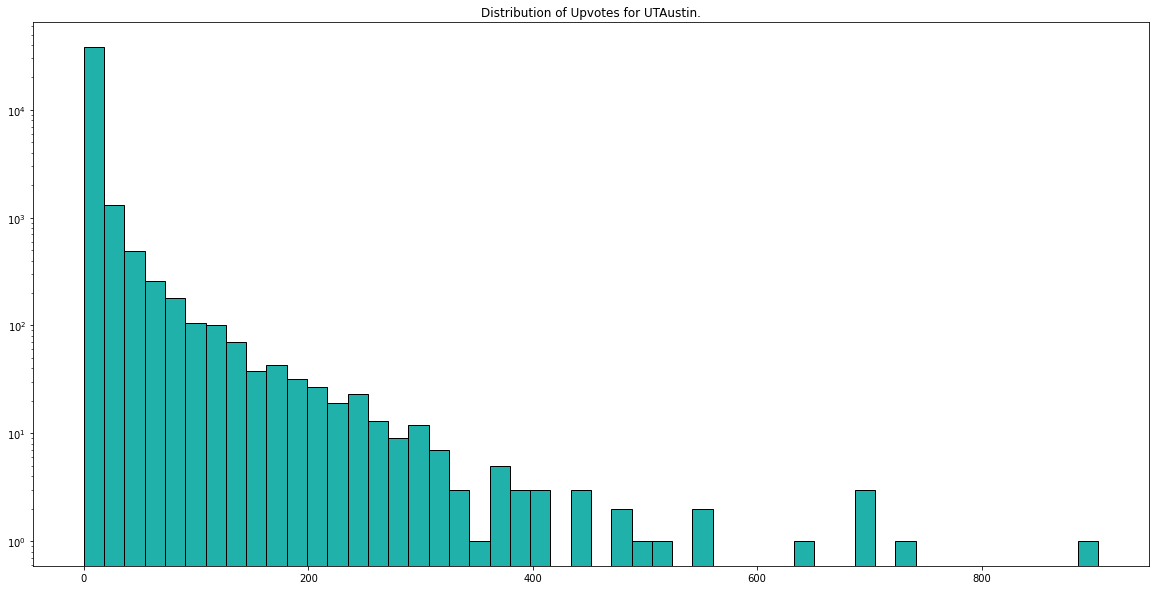

In [65]:
histogram(df, 'Upvotes', subreddit, log=True)

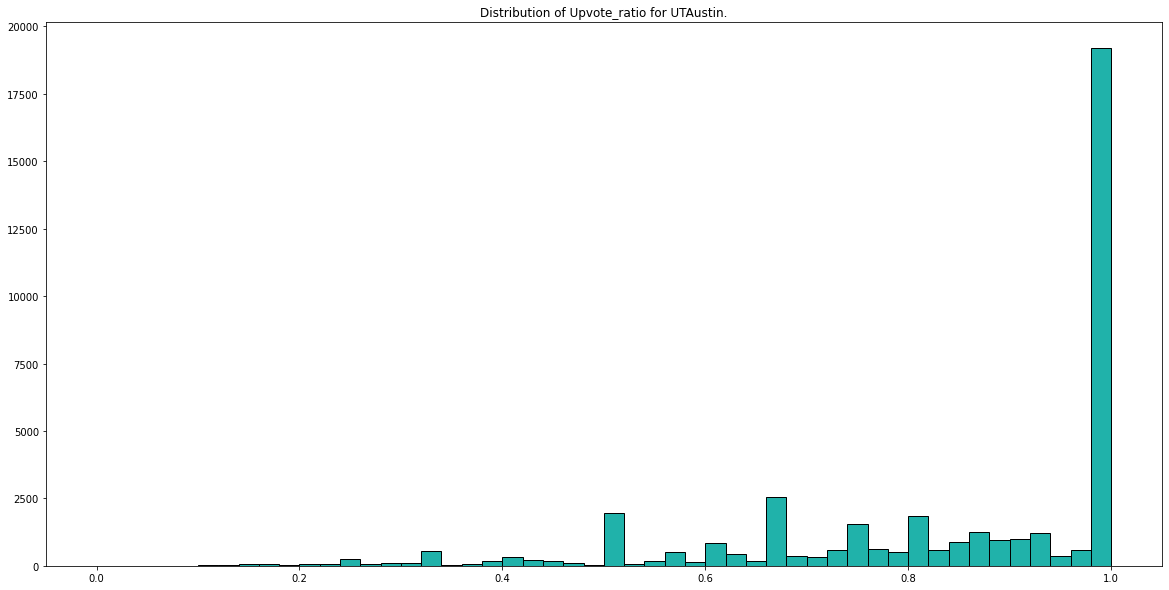

In [66]:
histogram(df, 'Upvote_ratio', subreddit)

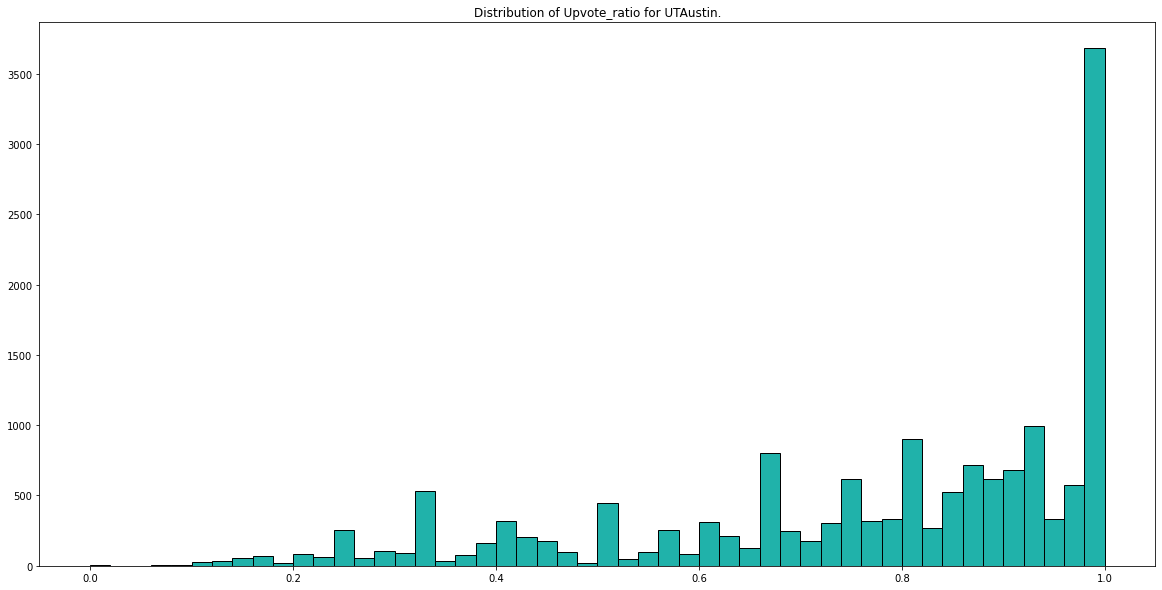

In [68]:
data = filterInteractions(df)
histogram(data, 'Upvote_ratio', subreddit)

# Training for Berkeley

In [69]:
X = getTextEmbeddings(data['Content'].to_numpy(), device='cuda')

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

In [70]:
y = getLabels(data)
X_train, X_test, y_train, y_test = ttSplit(X, y)

In [79]:
rfclf = sklearn.ensemble.RandomForestClassifier(128)
rfclf.fit(X_train, y_train)
train_pred = rfclf.predict(X_train)
test_pred = rfclf.predict(X_test)
print('train accuracy:', np.mean(train_pred == y_train))
calculateMetrics(test_pred, y_test)

train accuracy: 0.9990724996135415
test accuracy: 0.5523956723338486
f1 score: 0.26808460580069793
recall: 0.49594861366448617
[[  17    7    5]
 [  18   18   16]
 [ 574  828 1752]]


In [72]:
knnclf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=20)
knnclf.fit(X_train, y_train)
train_pred = knnclf.predict(X_train)
test_pred = knnclf.predict(X_test)
print('train accuracy:', np.mean(train_pred == y_train))
calculateMetrics(test_pred, y_test)

train accuracy: 0.6014840006183336
test accuracy: 0.5527047913446677
f1 score: 0.4102328309516243
recall: 0.4805783344366854
[[ 122   60   60]
 [ 104  161  208]
 [ 383  632 1505]]


In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_weights = torch.tensor([np.sum(y_train == i) for i in range(3)], dtype=torch.float, device=device)
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
print(class_weights)

tensor([2339., 3410., 7189.], device='cuda:0')


epoch:  1 loss:  tensor(179.0760, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  2 loss:  tensor(151.2477, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  3 loss:  tensor(148.5217, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  4 loss:  tensor(147.3871, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  5 loss:  tensor(146.5857, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  6 loss:  tensor(146.4125, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  7 loss:  tensor(145.4822, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  8 loss:  tensor(144.9025, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  9 loss:  tensor(144.6159, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  10 loss:  tensor(144.4614, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  11 loss:  tensor(141.8449, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  12 loss:  tensor(140.5701, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  13 loss:  tensor(140.1665, device='cuda:0', grad_fn=<AddBackward0>)
epoch:  14 loss:  ten

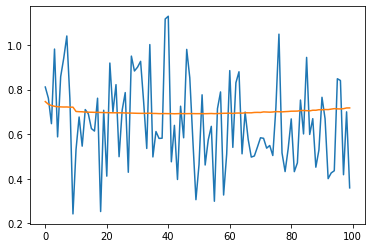

In [74]:
nnet = trainMlp(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, class_weights, device)

In [75]:
nnet.eval()
train_pred = torch.argmax(nnet(X_train_tensor), dim=1).cpu().numpy()
test_pred = torch.argmax(nnet(X_test_tensor), dim=1).cpu().numpy()
print('train accuracy:', np.mean(train_pred == y_train))
calculateMetrics(test_pred, y_test)

train accuracy: 0.6287679703199877
test accuracy: 0.5625965996908809
f1 score: 0.3306774341816522
recall: 0.4835602977168541
[[  85   24   30]
 [  31   23   31]
 [ 493  806 1712]]


In [78]:
gmmModels = trainGmms(X_train, y_train, X_test, y_test, 3, 2)

Number of Components 1
train accuracy: 0.8478126449219354
test accuracy: 0.5221020092735703
f1 score: 0.4618176009803492
recall: 0.47994536015182493
[[ 192   92  128]
 [ 180  338  486]
 [ 237  423 1159]]
Number of Components 2
train accuracy: 0.9368526820219508
test accuracy: 0.5428129829984544
f1 score: 0.425650206583265
recall: 0.47598276118050126
[[ 121   59   79]
 [ 138  239  298]
 [ 350  555 1396]]


In [31]:
gmm = gmmModels[0]
probs = []
for i in range(3):
    probs.append(gmm[i].score_samples(X))
best = [np.argsort(x)[-10:] for x in probs]
bestprobs = [np.sort(x)[-10:] for x in probs]
print(bestprobs[0])
print(best[0])
data.iloc[best[0]]

[926.01096178 926.51889528 928.14553152 928.30221943 928.42135002
 928.68743224 930.03282306 934.1776507  935.29607305 936.15206848]
[14630 13964   405 13322  4474  8933  4511 14449  7491  5741]


,Title,Text,Timestamp,Upvotes,Upvote_ratio,Num_comments,Nsfw,Text_Only,Subreddit,Url,Content,Num_votes
14630,CS Eng Freshman Schedule Question,"Hello,\n\nI'm pretty much between UMich and UI...",1.424120e+09,0,0.41,31,False,True,uofm,https://www.reddit.com/r/uofm/comments/2w46yp/...,"cs eng freshman schedule question hello,\n\ni'...",21.0
13964,Question about Ross School of Business (Partic...,Hey!\n\nSo... for those who are Ross undergrad...,1.445892e+09,0,0.18,4,False,True,uofm,https://www.reddit.com/r/uofm/comments/3qbto3/...,question about ross school of business (partic...,21.0
405,ross cross-transfer application,are there any current ross students that would...,1.646597e+09,0,0.40,0,False,True,uofm,https://www.reddit.com/r/uofm/comments/t871u8/...,ross cross-transfer application are there any ...,21.0
13322,LSA - CS + Ross?,Hi! I've posted before about my intent to majo...,1.468567e+09,0,0.31,12,False,True,uofm,https://www.reddit.com/r/uofm/comments/4sxz7r/...,lsa - cs + ross? hi! i've posted before about ...,21.0
4474,Sophomore Transfer - Just committed to UMich!,I recently committed to UMich for Fall 2021 as...,1.619285e+09,44,0.87,4,False,True,uofm,https://www.reddit.com/r/uofm/comments/mxoljb/...,sophomore transfer - just committed to umich! ...,58.0
8933,Applying to Ross,,1.570306e+09,0,0.27,1,False,True,uofm,https://www.reddit.com/r/uofm/comments/ddsli5/...,applying to ross,21.0
4511,Is it possible to transfer from LSA to Ross at...,# Is it possible to transfer from LSA to Ross ...,1.619080e+09,0,0.22,6,False,True,uofm,https://www.reddit.com/r/uofm/comments/mw0c3p/...,is it possible to transfer from lsa to ross at...,21.0
14449,Recommended classes for freshman LSA looking t...,,1.429415e+09,2,0.60,5,False,True,uofm,https://www.reddit.com/r/uofm/comments/333fpz/...,recommended classes for freshman lsa looking t...,10.0
7491,EECS 203 and 280 spring semester,\n\nIs anyone taking EECS 203 or 280 this spr...,1.588606e+09,8,0.75,11,False,True,uofm,https://www.reddit.com/r/uofm/comments/gddlvu/...,eecs 203 and 280 spring semester \n\nis anyon...,14.0
5741,Umich transfers,I’m a freshman at another university right now...,1.605754e+09,5,0.86,36,False,True,uofm,https://www.reddit.com/r/uofm/comments/jwuini/...,umich transfers i’m a freshman at another univ...,5.0
